In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
IMG_SIZE = (48, 48)
BATCH_SIZE = 64

# Load the pre-trained ResNet50 model without the top layer (classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers to avoid retraining them
base_model.trainable = False


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    'images/train/',  # Path to train folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',  # FER images are grayscale
    class_mode='categorical',
    shuffle=True
)

# Load test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'images/test/',  # Path to test folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [16]:
model = Sequential()

# Add the base model (ResNet50) as the feature extractor
model.add(base_model)

# Add custom classification head
model.add(GlobalAveragePooling2D())  # Pooling layer to reduce spatial dimensions
model.add(Dense(256, activation='relu'))  # Fully connected layer
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Dropout to avoid overfitting
model.add(Dense(7, activation='softmax'))  # Output layer (7 emotion classes)

In [19]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,079 (91.99 MB)

 Trainable params: 526,855 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_transfer_learning.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 163s 345ms/step - accuracy: 0.1763 - loss: 2.2689 - val_accuracy: 0.2382 - val_loss: 1.8685
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 239ms/step - accuracy: 0.2429 - loss: 1.9946 - val_accuracy: 0.2845 - val_loss: 1.8412
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 126s 281ms/step - accuracy: 0.2704 - loss: 1.8909 - val_accuracy: 0.2979 - val_loss: 1.8073
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 335ms/step - accuracy: 0.2869 - loss: 1.8557 - val_accuracy: 0.2657 - val_loss: 1.8517
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 119s 265ms/step - accuracy: 0.2994 - loss: 1.8014 - val_accuracy: 0.2562 - val_loss: 1.8468
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 131s 291ms/step - accuracy: 0.2923 - loss: 1.7854 - val_accuracy: 0.3352 - val_loss: 1.7080
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 116s 257ms/step - accuracy: 0.3028 - loss: 1.7666 - val_accuracy: 0.3292 - val_loss: 1.7475
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 251ms/step - accuracy: 0.3106 -

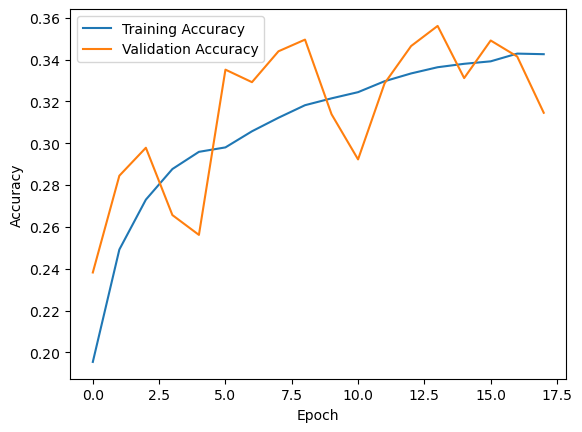

In [22]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Save the final model
model.save('emotion_model_transfer_learning.keras')

113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.2826 - loss: 1.7324
Test Accuracy: 34.65%


In [39]:
# Load the model for predictions
from tensorflow.keras.models import load_model
loaded_model = load_model('emotion_model_transfer_learning.keras')
IMG_SIZE = (48, 48)
# Example prediction function
def predict_emotion(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=IMG_SIZE,
        color_mode='rgb'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = loaded_model.predict(img_array)
    emotion_index = np.argmax(prediction)
    emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    return emotions[emotion_index]


print(predict_emotion(r"C:\Users\ashis\OneDrive\Desktop\abc.jpg"))

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


<IPython.core.display.Javascript object>

Happy
